In [1]:
import base64
import json
import io
import os
import requests
import oci
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import math

In [2]:
config = oci.config.from_file('~/.oci/config')
ai_service_vision_client = oci.ai_vision.AIServiceVisionClient(config=config)

In [3]:
def draw_player_field_markers(image_objects, img, field_to_camera):
    # Draws a 1 by 1 meter box right below the feet of the player
    color = (255, 0, 0)
    for image_object in image_objects:
        world_coordinates = image_object["world_coordinates"]
        if "display" in image_object and image_object["name"] == "Person":
            draw_line_with_field_coordinates([world_coordinates[0]-0.5, world_coordinates[1]], [world_coordinates[0]+0.5, world_coordinates[1]], img, 10, color, field_to_camera)
            draw_line_with_field_coordinates([world_coordinates[0]-0.5, world_coordinates[1]], [world_coordinates[0]-0.5, world_coordinates[1]+1], img, 10, color, field_to_camera)
            draw_line_with_field_coordinates([world_coordinates[0]+0.5, world_coordinates[1]], [world_coordinates[0]+0.5, world_coordinates[1]+1], img, 10, color, field_to_camera)
            draw_line_with_field_coordinates([world_coordinates[0]-0.5, world_coordinates[1]+1], [world_coordinates[0]+0.5, world_coordinates[1]+1], img, 10, color, field_to_camera)


In [4]:
def remove_unwanted_objects(image_objects):
    for index, image_object in enumerate(image_objects):
        # Only include objects inside of the field (looking at the real world coordinates), otherwise it's likely a referree/audience/reporter or other object
        world_coordinate = image_object["world_coordinates"]
        label = image_object["name"]
        if world_coordinate[0] > 0 and world_coordinate[0] < FIELD_WIDTH and world_coordinate[1] > (-FIELD_HEIGHT / 2) and world_coordinate[1] < (FIELD_HEIGHT / 2):
            image_object["display"] = "Y"


In [5]:
def is_point_within_rectangle(object_rectangle, text_rectangle):
    # This checks whether the text is within a players bounding box (and therefore a shirt number)
    minX = 1
    maxX = 0
    minY = 1
    maxY = 0
    for coordinate in object_rectangle:
        if coordinate["x"] < minX:
            minX = coordinate["x"]
        if coordinate["y"] < minY:
            minY = coordinate["y"]
        if coordinate["x"] > maxX:
            maxX = coordinate["x"]
        if coordinate["y"] > maxY:
            maxY = coordinate["y"]
    result = text_rectangle[0]["x"] > minX and text_rectangle[0]["y"] > minY and text_rectangle[0]["x"] < maxX and text_rectangle[0]["y"] < maxY and text_rectangle[1]["x"] > minX and text_rectangle[1]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[1]["y"] < maxY and text_rectangle[2]["x"] > minX and text_rectangle[2]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[2]["y"] < maxY and text_rectangle[3]["x"] > minX and text_rectangle[3]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[3]["y"] < maxY
    return result


In [6]:
# Field height and width can vary
FIELD_HEIGHT = 65
FIELD_WIDTH = 105

field_coordinates = np.array([
    # Left
    [0, 0], # Left side, center of goal on goal line
    [0, 7.32 / 2], # Left side, top of goal
    [0, -7.32 / 2], # Left side, bottom of goal
    [11, 0], # Left side, penalty spot
    [0, (7.32 / 2) + 5.5], # Left side, top outer corner of goal area
    [0, (-7.32 / 2) - 5.5], # Left side, bottom outer corner of goal area
    [5.5, (7.32 / 2) + 5.5], # Left side, top inner corner of goal area
    [5.5, (-7.32 / 2) - 5.5], # Left side, bottom inner corner of goal area
    [0, (7.32 / 2) + 16.5], # Left side, top outer corner of penalty area
    [0, (-7.32 / 2) - 16.5], # Left side, bottom outer corner of penalty area
    [16.5, (7.32 / 2) + 16.5], # Left side, top inner corner of penalty area
    [16.5, (-7.32 / 2) - 16.5], # Left side, bottom inner corner of penalty area
    [16.5, 7.31], # Left side, top of intersection of penalty arc with penalty area line (7.31 was calculated previously)
    [16.5, -7.31], # Left side, bottom of intersection of penalty arc with penalty area line (7.31 was calculated previously)
    [0, FIELD_HEIGHT / 2], # Left side, top corner of field
    [0, -FIELD_HEIGHT / 2], # Left side, bottom corner of field
    # Right
    [FIELD_WIDTH, 0], # Right side, center of goal on goal line
    [FIELD_WIDTH, 7.32 / 2], # Right side, top of goal
    [FIELD_WIDTH, -7.32 / 2], # Right side, bottom of goal
    [FIELD_WIDTH-11, 0], # Right side, penalty spot
    [FIELD_WIDTH, (7.32 / 2) + 5.5], # Right side, top outer corner of goal area
    [FIELD_WIDTH, (-7.32 / 2) - 5.5], # Right side, bottom outer corner of goal area
    [FIELD_WIDTH-5.5, (7.32 / 2) + 5.5], # Right side, top inner corner of goal area
    [FIELD_WIDTH-5.5, (-7.32 / 2) - 5.5], # Right side, bottom inner corner of goal area
    [FIELD_WIDTH, (7.32 / 2) + 16.5], # Right side, top outer corner of penalty area
    [FIELD_WIDTH, (-7.32 / 2) - 16.5], # Right side, bottom outer corner of penalty area
    [FIELD_WIDTH-16.5, (7.32 / 2) + 16.5], # Right side, top inner corner of penalty area
    [FIELD_WIDTH-16.5, (-7.32 / 2) - 16.5], # Right side, bottom inner corner of penalty area
    [FIELD_WIDTH-16.5, 7.31], # Right side, top of intersection of penalty arc with penalty area line (7.31 was calculated previously)
    [FIELD_WIDTH-16.5, -7.31], # Right side, bottom of intersection of penalty arc with penalty area line (7.31 was calculated previously)
    [FIELD_WIDTH, FIELD_HEIGHT / 2], # Right side, top corner of field
    [FIELD_WIDTH, -FIELD_HEIGHT / 2], # Right side, bottom corner of field
    # Middle stuff
    [FIELD_WIDTH / 2, FIELD_HEIGHT / 2], # Top of middle line
    [FIELD_WIDTH / 2, -FIELD_HEIGHT / 2], # Bottom of middle line
    [FIELD_WIDTH / 2, 0], # Center spot
])

In [7]:
def draw_line_with_field_coordinates(field_coordinate1, field_coordinate2, img, line_width, color, field_to_camera):
    # Draws a line on the image, taking as input real world coordinates (in meters on the pitch)
    # It translates the pitch coordinates to pixels on the image using the field_to_camera translation matrix first
    a = np.array([field_coordinate1], dtype='float32')
    a = np.array([a])
    b = np.array([field_coordinate2], dtype='float32')
    b = np.array([b])
    pointsOut1 = cv2.perspectiveTransform(a, field_to_camera)
    pointsOut2 = cv2.perspectiveTransform(b, field_to_camera)
    coordinate1 = pointsOut1[0][0]
    coordinate1int = coordinate1.astype(int)
    coordinate1tuple = (coordinate1int[0], coordinate1int[1])
    coordinate2 = pointsOut2[0][0]
    coordinate2int = coordinate2.astype(int)
    coordinate2tuple = (coordinate2int[0], coordinate2int[1])
    cv2.line(img, coordinate1tuple, coordinate2tuple, color, line_width)
def draw_field(img):
    # Left penalty area
    color = (255, 255, 255)
    draw_line_with_field_coordinates(field_coordinates[8], field_coordinates[10], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[10], field_coordinates[11], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[11], field_coordinates[9], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[9], field_coordinates[8], img, 5, color, field_to_camera)
    # Left goal area
    draw_line_with_field_coordinates(field_coordinates[4], field_coordinates[6], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[6], field_coordinates[7], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[7], field_coordinates[5], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[5], field_coordinates[4], img, 5, color, field_to_camera)
    # Right penalty area
    draw_line_with_field_coordinates(field_coordinates[8+16], field_coordinates[10+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[10+16], field_coordinates[11+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[11+16], field_coordinates[9+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[9+16], field_coordinates[8+16], img, 5, color, field_to_camera)
    # Left goal area
    draw_line_with_field_coordinates(field_coordinates[4+16], field_coordinates[6+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[6+16], field_coordinates[7+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[7+16], field_coordinates[5+16], img, 5, color, field_to_camera)
    draw_line_with_field_coordinates(field_coordinates[5+16], field_coordinates[4+16], img, 5, color, field_to_camera)
    # Middle line
    draw_line_with_field_coordinates(field_coordinates[32], field_coordinates[33], img, 5, color, field_to_camera)
    # Distance lines
    for i in range(0, FIELD_WIDTH, 2):
        draw_line_with_field_coordinates([i, -FIELD_HEIGHT / 2], [i, FIELD_HEIGHT / 2], img, 1, color, field_to_camera)
    for i in range(0, FIELD_HEIGHT, 2):
        draw_line_with_field_coordinates([0, i - (FIELD_HEIGHT / 2)], [FIELD_WIDTH, i - (FIELD_HEIGHT / 2)], img, 1, color, field_to_camera)


In [8]:
def add_object_world_coordinates(image_objects, img, camera_to_field):
    # Translates pixels coordinates of the objects to real world pitch coordinates
    for image_object in image_objects:
        width = img.shape[1]
        height = img.shape[0]
        vertices = image_object["bounding_polygon"]["normalized_vertices"]
        vertex_x = vertices[0]['x'] * width
        vertex_y = vertices[0]['y'] * height
        box_width = (vertices[2]['x'] - vertices[0]['x']) * width
        box_height = (vertices[2]['y'] - vertices[0]['y']) * height
        camera_location = np.array([[int(vertex_x + (box_width / 2)), int(vertex_y + box_height)]], dtype='float32')
        camera_location = np.array([camera_location])
        world_location = cv2.perspectiveTransform(camera_location, camera_to_field)
        world_location = [float(world_location[0][0][0]), float(world_location[0][0][1])]
        image_object["world_coordinates"] = world_location


In [9]:
def add_shirt_number_to_players(vision_response):
    # Adds the shirt numbers to the players
    # Does this by checking whether the recognized text is within the bounding box of the player
    for image_object in vision_response["image_objects"]:
        # Loop through all of the texts found
        # Check if it is within the bounds of this player
        # If it is, then set it as the shirt number
        for line in vision_response["image_text"]["lines"]:
                result = is_point_within_rectangle(image_object["bounding_polygon"]["normalized_vertices"], line["bounding_polygon"]["normalized_vertices"])
                if (result is True):
                    if line["text"].isnumeric():
                        print("Found shirt number", line["text"])
                        image_object["shirt_number"] = line["text"]
                    else:
                        print("Ignoring non-number shirt text", line["text"])


In [10]:
def draw_player_info(image_objects, img):
    # Draws the box at the feet of the player
    # This uses real world pitch coordinates, therefore follows perspective of the image
    for image_object in image_objects:
        width = img.shape[1]
        height = img.shape[0]
        vertices = image_object["bounding_polygon"]["normalized_vertices"]
        label = image_object["name"]
        vertex_x = vertices[0]['x'] * width
        vertex_y = vertices[0]['y'] * height
        box_width = (vertices[2]['x'] - vertices[0]['x']) * width
        box_height = (vertices[2]['y'] - vertices[0]['y']) * height                        
        if label == "Person" and ("display" in image_object):
            if "shirt_number" in image_object:
                start_point = (int(vertex_x), int(vertex_y + box_height))
                end_point = (int(vertex_x + box_width), int(vertex_y + box_height + 30))
                color = (0, 0, 0)
                #cv2.rectangle(img, start_point, end_point, color, -1)
                cv2.putText(img, image_object["shirt_number"], (int(vertex_x + 15), int(vertex_y + box_height + 30)), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255, 255, 255), 3, 2)


In [11]:
def enrich_shirt_numbers_from_tracked_players(image_objects, tracked_players):
    for tracked_player in tracked_players:
        # Find the nearest player in the current frame
        #print("Trying to find best fitting player for coordinates ", tracked_player["world_coordinates"], " and shirt number", tracked_player["shirt_number"])
        shortest_distance = 99999
        image_object_with_shortest_distance = {}
        for image_object in image_objects:
            world_location_tracked = tracked_player["world_coordinates"]
            world_location_frame = image_object["world_coordinates"]
            distance = math.sqrt(((world_location_frame[0] - world_location_tracked[0]) * (world_location_frame[0] - world_location_tracked[0])) + ((world_location_frame[1] - world_location_tracked[1]) * (world_location_frame[1] - world_location_tracked[1])))
            if (distance < shortest_distance):
                shortest_distance = distance
                image_object_with_shortest_distance = image_object
        image_object_with_shortest_distance["shirt_number"] = tracked_player["shirt_number"]
        #print("setting shirt_number for player at distance", shortest_distance, tracked_player["shirt_number"])
    # Reset tracked players
    # Simply keep track of all the players with a shirt number
    tracked_players = []
    for image_object in image_objects:
        if "shirt_number" in image_object:
            tracked_player = {}
            tracked_player["shirt_number"] = image_object["shirt_number"]
            tracked_player["world_coordinates"] = image_object["world_coordinates"]
            tracked_players.append(tracked_player)
    return tracked_players


In [12]:
def store_tracking_information(image_objects, frame_number, connection, cur):
    # Stores the tracking information that was derived from the image in the database
    for index, image_object in enumerate(image_objects):
        world_coordinate = image_object["world_coordinates"]
        if "display" in image_object:
            sql = ""
            if image_object["name"] == "Person":
                shirt_number = "null"
                if "shirt_number" in image_object:
                    shirt_number = image_object["shirt_number"]
                sql = "insert into tracking(framenumber, object, shirt_number, position_x, position_y) values (" + str(frame_number) + ", 'Player', " + shirt_number + ", " + str(image_object["world_coordinates"][0]) + ", " + str(image_object["world_coordinates"][1]) + ")"
            if image_object["name"] == "Football":
                sql = "insert into tracking(framenumber, object, position_x, position_y) values (" + str(frame_number) + ", \'Ball\', " + str(image_object["world_coordinates"][0]) + ", " + str(image_object["world_coordinates"][1]) + ")"
            cur.execute(sql)
    connection.commit()


In [13]:
def initialize_database_connection_and_table():
    # Initializes the connection to the database (we will use this to store the tracking information)
    import oracledb
    connection = oracledb.connect(
        user='admin',
        password='_Oracle12345',
        dsn='pl_high',
        config_dir='/home/datascience/wallet',
        wallet_location='/home/datascience/wallet',
        wallet_password='_Oracle12345')
    cur = connection.cursor()
    try:
        cur.execute("create table tracking(framenumber number, object varchar2(10), shirt_number number, position_x number, position_y number)")
    except Exception:
        print("Could not create the tracking table, moving on...")
    try:
        cur.execute("truncate table tracking")
    except Exception:
        print("Could not empty the tracking table")
    return connection, cur


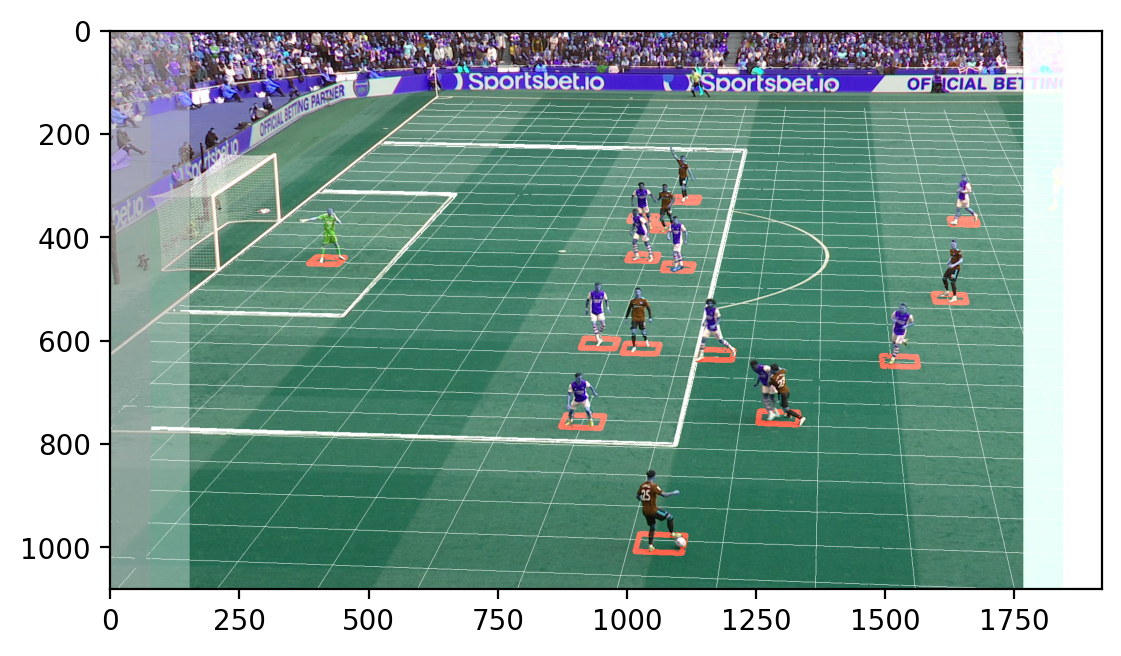

Writing to video, frame 6


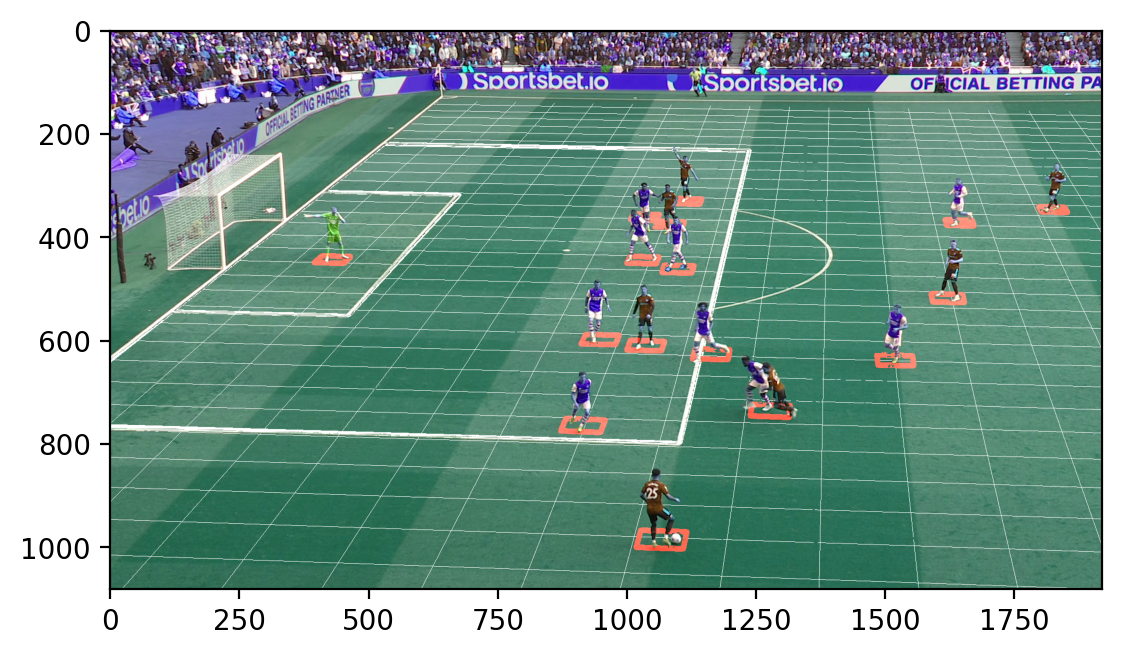

Writing to video, frame 7


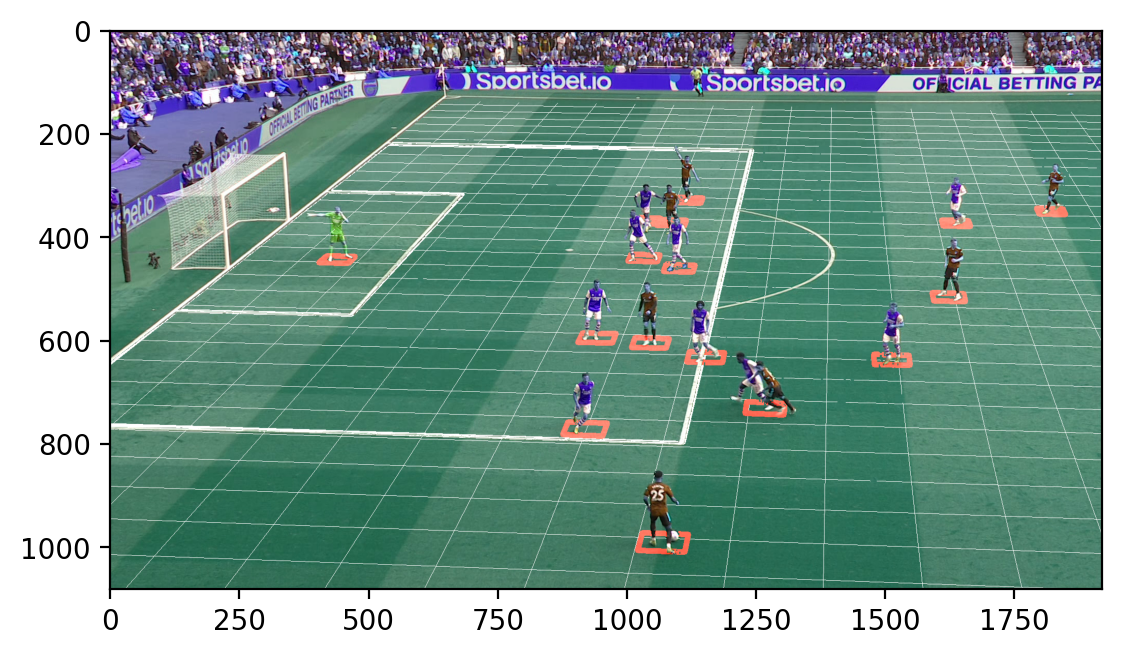

Writing to video, frame 8
Ignoring non-number shirt text (a


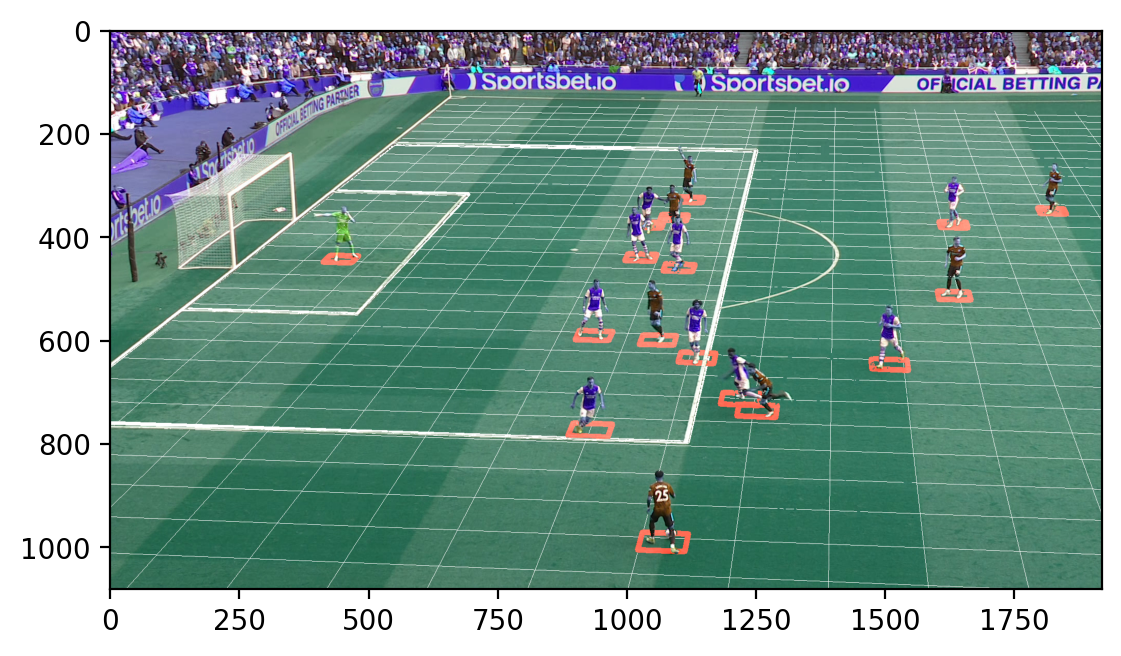

Writing to video, frame 9
Found shirt number 25


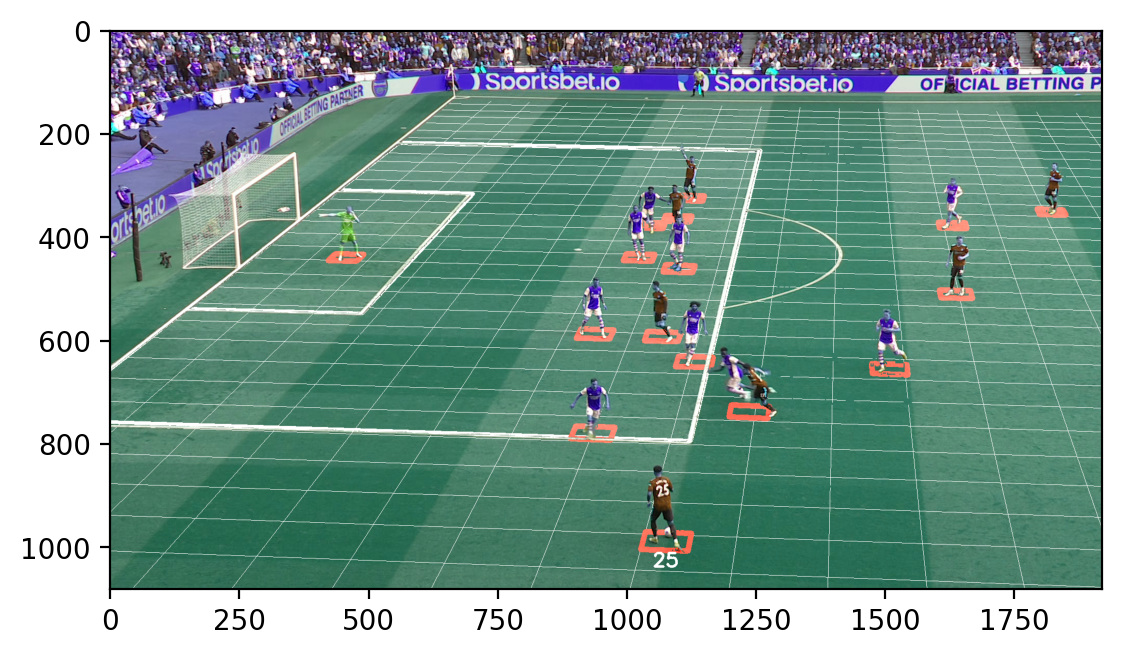

Writing to video, frame 10
Found shirt number 2


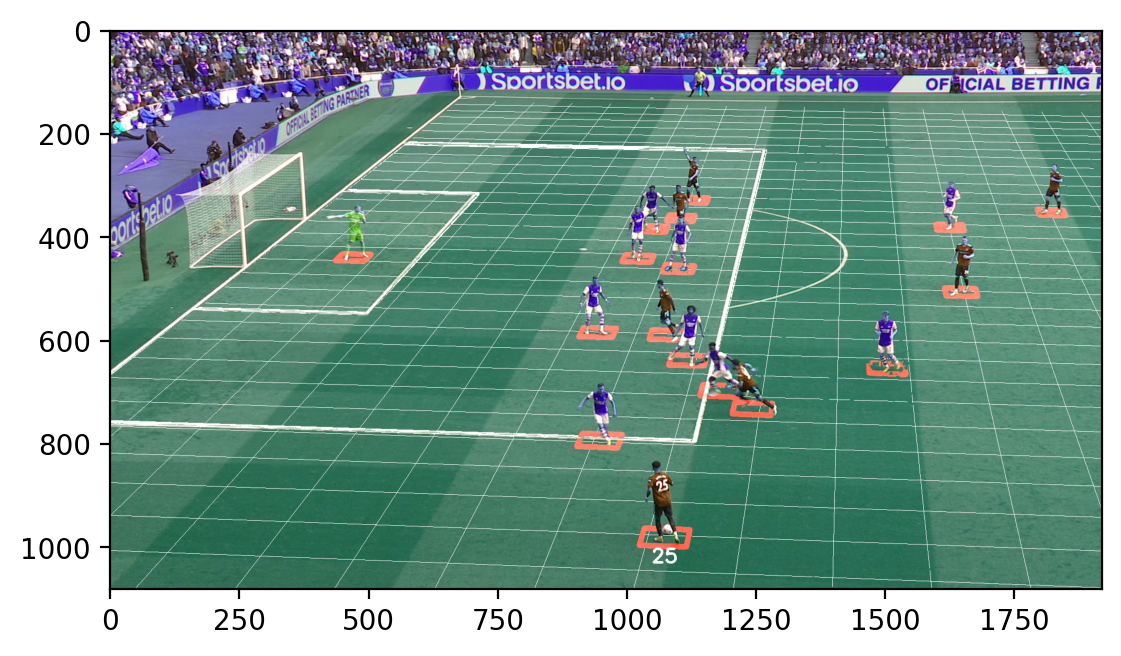

Writing to video, frame 11


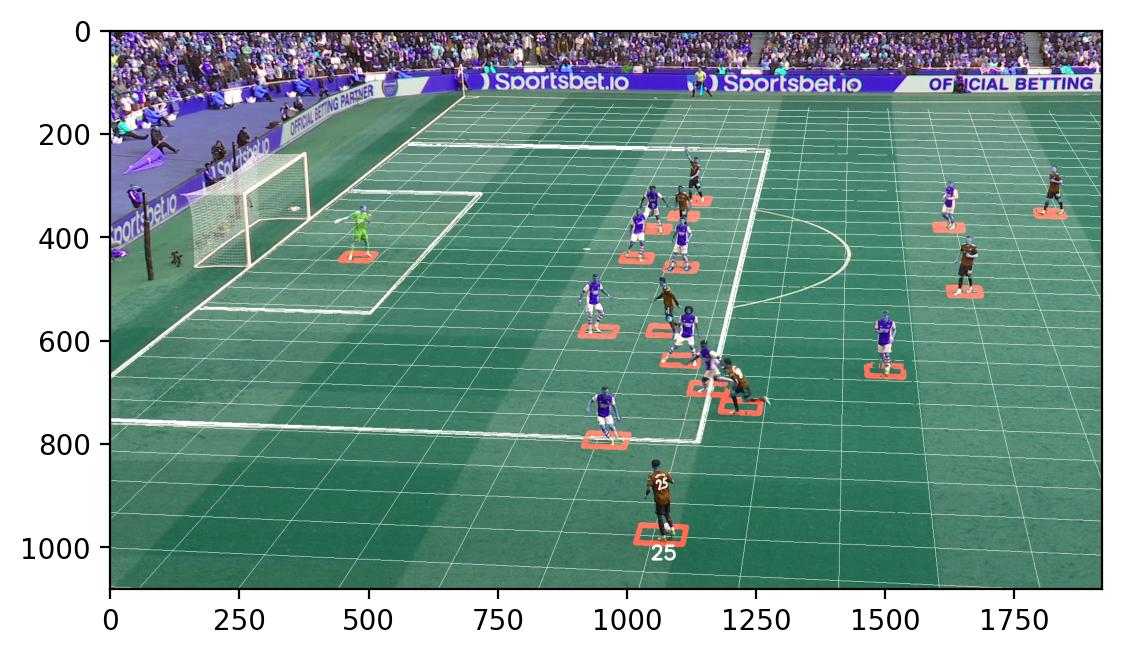

Writing to video, frame 12


In [15]:
# Connect to the database
!pip install oracledb

#UNCOMMENT THE FOLLOWING LINE IF YOU WISH TO WRITE THE TRACKING INFORMATION TO THE DATABASE
#connection, cur = initialize_database_connection_and_table()

# Read the precalculated homography translation matrices (for all frames)
f = open('coordinate_pairs.json', 'r')
homographyStr = f.read()
homographyDict = json.loads(homographyStr)

# Configure features parameter for call to AI Vision service
analyze_image_details = oci.ai_vision.models.AnalyzeImageDetails()
inline_image_details = oci.ai_vision.models.InlineImageDetails()
image_object_detection_feature = oci.ai_vision.models.ImageObjectDetectionFeature()
image_object_detection_feature.max_results = 50 # We don't expect more than 50 objects
image_text_detection_feature = oci.ai_vision.models.ImageTextDetectionFeature()
features = [image_object_detection_feature, image_text_detection_feature]

# Video reader
filename = 'video.mp4'
cap = cv2.VideoCapture(filename)

# Video writer
out = cv2.VideoWriter('soccer_out.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (1920, 1080))

#Remove the first few frames (because it has a video overlay on top of the field)
for i in range(1, 15):
    ret, image_np = cap.read()
    
tracked_players = [] # Empty list

frame_number = 6
while (frame_number <= 12):
    # Read three frames from the video (we are skipping 2 frames, then processing the third)
    ret, image_np = cap.read()
    ret, image_np = cap.read()
    ret, image_np = cap.read()
    _, im_arr = cv2.imencode('.jpg', image_np)  # im_arr: image in Numpy one-dim array format.
    
    # Call the AI Vision service to do object recognition and text recognition
    im_bytes = im_arr.tobytes()
    im_b64 = base64.b64encode(im_bytes)
    inline_image_details.data = im_b64.decode('utf-8')
    analyze_image_details.image = inline_image_details
    analyze_image_details.features = features
    res = ai_service_vision_client.analyze_image(analyze_image_details=analyze_image_details)
    res_json = json.loads(repr(res.data))
    
    # Calculate the translation matrix for the current frame
    frame_coordinate_pairs = homographyDict[str(frame_number)]
    pts_dst = np.array([frame_coordinate_pairs[0]["worldCoordinate"], frame_coordinate_pairs[1]["worldCoordinate"], frame_coordinate_pairs[2]["worldCoordinate"], frame_coordinate_pairs[3]["worldCoordinate"]])
    pts_src = np.array([frame_coordinate_pairs[0]["cameraCoordinate"], frame_coordinate_pairs[1]["cameraCoordinate"], frame_coordinate_pairs[2]["cameraCoordinate"], frame_coordinate_pairs[3]["cameraCoordinate"]])
    camera_to_field, status = cv2.findHomography(pts_src, pts_dst)
    field_to_camera, status = cv2.findHomography(pts_dst, pts_src)

    # Data enrichment
    add_object_world_coordinates(res_json["image_objects"], image_np, camera_to_field)
    remove_unwanted_objects(res_json["image_objects"])
    add_shirt_number_to_players(res_json)
    tracked_players = enrich_shirt_numbers_from_tracked_players(res_json["image_objects"], tracked_players)

    # Create a mask for the underlying field (all the green pixels + some white pixels for the lines)
    img_hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
    white_mask = cv2.inRange(image_np, (213, 225, 204), (255, 255, 255))
    lower_green = np.array([40,40, 40])
    upper_green = np.array([70, 255, 255])
    green_mask = cv2.inRange(img_hsv, lower_green, upper_green)
    white_or_green_mask = cv2.bitwise_or(green_mask, white_mask)
    
    # Create an image of the same size as the original that will contain the augmentation elements (field lines, player marks, et cetera)
    drawing_canvas = np.zeros(image_np.shape[:3], dtype="uint8")
    #drawPlayerBoxes(clean_res, image_np)
    draw_field(drawing_canvas)
    draw_player_field_markers(res_json["image_objects"], drawing_canvas, field_to_camera)
    draw_player_info(res_json["image_objects"], drawing_canvas)
    
    # Remove the drawn elements in areas where there are no field pixels (effectively not drawing where there is a player or ball)
    drawing_canvas_masked = cv2.bitwise_and(drawing_canvas, drawing_canvas, mask=white_or_green_mask)
    img_augmented = cv2.bitwise_or(drawing_canvas_masked, image_np)

    plt.imshow(img_augmented)
    plt.gcf().set_dpi(200)
    plt.show()
    
    # Add the resulting frame (with annotation) to the output video
    print("Writing to video, frame", frame_number)
    out.write(img_augmented)
    
    #UNCOMMENT THE FOLLOWING LINE IF YOU WISH TO WRITE THE TRACKING INFORMATION TO THE DATABASE
    #store_tracking_information(res_json["image_objects"], frame_number, connection, cur)

    frame_number += 1
cap.release()
out.release()